# Sentiment Analysis
- Brigitte Hogan (bwh5v@virginia.edu) & Jason Tiezzi (jbt5am@virginia.edu)
- DS 5001: Exploratory Text Analytics
- April 2020

## Overview

This notebook calculates the sentiment for both the book and the time period, first using VADER and then using a pure lexicon-based approach (EmoLex, from NRC). It also calculates emotional dimension scores based on EmoLex. 

## Set Up

In [20]:
OHCO = ['period','book_id', 'vol_num','chap_num', 'recp_num','para_num', 'sent_num', 'token_num']

### Import Libraries

In [21]:
import pandas as pd
import numpy as np
import os
import datetime
import re
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import seaborn as sns
sns.set()
import math
import nltk


In [22]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

### Import Files

In [4]:
file_dir = 'C:/Users/Jason/Documents/Data Science/Spring 2020/Text Analytics/final_project/DS5001-Text-Analytics/'
data_dir = 'Tables/'
#os.chdir(file_dir)

In [5]:
LIB = pd.read_csv(data_dir + 'LIB.csv')
LIB.head()

,book_id,author_last,author_full,book_year,book_title,book_file,period
0,9935,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s
1,9936,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 2",Cookbooks\WIDAS1923_WILCV02_pg9936.txt,1900s
2,9937,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 3",Cookbooks\WIDAS1923_WILCV03_pg9937.txt,1900s
3,9938,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 4",Cookbooks\WIDAS1923_WILCV04_pg9938.txt,1900s
4,9939,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 5",Cookbooks\WIDAS1923_WILCV05_pg9939.txt,1900s


In [6]:
VOCAB = pd.read_csv(data_dir + 'VOCAB.csv')
VOCAB.head()

,term_id,term_str,Unnamed: 2,n,num,has_int,stop,stem_porter,stem_snowball
0,1,0,NaN,69,1,1,0,0,0
1,2,0,NaN,1,1,1,0,0,0
2,14,1,NaN,4035,1,1,0,1,1
3,3,1,NaN,1,1,1,0,1,1
4,5,1,NaN,1,1,1,0,1,1


In [7]:
TOKEN = pd.read_csv(data_dir + 'TOKEN.csv')
TOKEN.head()

,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str
0,9935,1,1,1.0,0,0,0,"('1', 'CD')",CD,1,1
1,9935,1,1,1.0,0,0,1,"('.', '.')",.,.,NaN
2,9935,1,1,1.0,0,1,0,"('Without', 'IN')",IN,Without,without
3,9935,1,1,1.0,0,1,1,"('doubt', 'NN')",NN,doubt,doubt
4,9935,1,1,1.0,0,1,2,"(',', ',')",",",",",NaN


In [8]:
TOKEN.shape

(1130904, 11)

In [9]:
#merging the library and TOKEN tables together
TOKEN = pd.merge(TOKEN, LIB, on="book_id", how="left")
TOKEN.shape

(1130904, 17)

In [10]:
#merging the token and VOCAB tables together os I can have access to stop words, numbers, etc. 
TOKEN = pd.merge(TOKEN, VOCAB, on='term_str')
TOKEN.head()

,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,author_last,author_full,book_year,book_title,book_file,period,term_id,Unnamed: 2,n,num,has_int,stop,stem_porter,stem_snowball
0,9935,1,1,1.0,0,0,0,"('1', 'CD')",CD,1,1,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,14,NaN,4035,1,1,0,1,1
1,9935,1,1,1.0,0,0,0,"('1', 'CD')",CD,1,1,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,3,NaN,1,1,1,0,1,1
2,9935,1,1,1.0,0,0,0,"('1', 'CD')",CD,1,1,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,5,NaN,1,1,1,0,1,1
3,9935,1,5,23.0,0,7,25,"('1', 'CD')",CD,1,1,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,14,NaN,4035,1,1,0,1,1
4,9935,1,5,23.0,0,7,25,"('1', 'CD')",CD,1,1,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,3,NaN,1,1,1,0,1,1


## VADER

In [11]:
## getting the corpus into sentences for analysis by VADER
TOKEN = TOKEN.sort_values(by=OHCO)
sent_frame = TOKEN.groupby(OHCO[:7]).token_str.apply(lambda x: ' '.join(x)).to_frame() #getting a string for each sentence 
sent_frame.columns = ['sent_str']
sent_frame

sent_str
period   book_id vol_num chap_num recp_num para_num sent_num                                                                                                                                                                                                                                                                                                                                                         
1900s    9935    1       1        1.0      0        0                                                                                                                                                                                                                                                                                                                                                           1 1 1
                                                    1                                                                                                                                                                                                                                                                                   Without doubt the greatest problem confronting the human race is that of food
                                                    2                                                                                                                                                                                                                                                                In order to exist every person must eat but eating simply to keep life in the body is not enough
                                                    3                                                                                                                                                                               Aside from this the body must be supplied with an ample amount of energy to carry on each day 's work as well as with the material needed for its growth repair and working power
                                                    4                                                                                                                                                                                                                      To meet these requirements of the human body there is nothing to take the place of _food_ not merely any kind however but the _right_ kind
...                                                                                                                                                                                                                                                                                                                                                                                                               ...
mid1800s 28681   5       37       38.0     1        4                                                                                                                                                                                                                                                                                On one side there is a part whiter than ordinary by some called the white muscle
                                                    5         In some places a buttock is generally divided and this white part sold separate as a delicacy but it is by no means so the meat being coarse and dry whereas the darker coloured parts though apparently of a coarser grain are of a looser texture more tender fuller of gravy and better flavoured and men of distinguishing palates ever prefer them
                                  39.0     1        0                                                                                                                                                                                                                                                    412 He who greedily grapples for the pri

### Running VADER

In [12]:
def get_sentiment(series): #creating a function to get VADER sentiment of a series
    cols = len(series) #getting the length of the series column
    series = series.reset_index(drop=True)
    sent = np.empty((cols,4)) #creating an empty array to store my results
    for i in range(cols):
        sentence = series[i]
        score = analyzer.polarity_scores(sentence) #getting the four different sentiment values
        sent[i,:] = list(score.values()) #pulling the values out of dictionary and putting them into the array I created
    return sent

In [13]:
text = sent_frame.sent_str 
sentiment_score = get_sentiment(text) 
sentiment_score 

array([[ 0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.219 ,  0.459 ,  0.322 ,  0.4606],
       [ 0.    ,  1.    ,  0.    ,  0.    ],
       ...,
       [ 0.146 ,  0.854 ,  0.    , -0.4404],
       [ 0.    ,  1.    ,  0.    ,  0.    ],
       [ 0.    ,  1.    ,  0.    ,  0.    ]])

In [24]:
#adding the results of VADER to my sentence dataframe
sent_frame['VADER_pos'] = sentiment_score[:,2]
sent_frame['VADER_neg'] = sentiment_score[:,0]
sent_frame['VADER_neu'] = sentiment_score[:,1]
sent_frame['VADER_compound'] = sentiment_score[:,3]
sent_frame.head()



sent_str  \
period book_id vol_num chap_num recp_num para_num sent_num                                                                                                                                                                                      
1900s  9935    1       1        1.0      0        0                                                                                                                                                                                     1 1 1   
                                                  1                                                                                                             Without doubt the greatest problem confronting the human race is that of food   
                                                  2                                                                                          In order to exist every person must eat but eating simply to keep life in the body is not enough   
                                                  3         Aside from this the body must be supplied with an ample amount of energy to carry on each day 's work as well as with the material needed for its growth repair and working power   
                                                  4                                                To meet these requirements of the human body there is nothing to take the place of _food_ not merely any kind however but the _right_ kind   

                                                            VADER_pos  \
period book_id vol_num chap_num recp_num para_num sent_num              
1900s  9935    1       1        1.0      0        0             0.000   
                                                  1             0.322   
                                                  2             0.000   
                                                  3             0.175   
                                                  4             0.000   

                                                            VADER_neg  \
period book_id vol_num chap_num recp_num para_num sent_num              
1900s  9935    1       1        1.0      0        0             0.000   
                                                  1             0.219   
                                                  2             0.000   
                                                  3             0.000   
                                                  4             0.188   

                                                            VADER_neu  \
period book_id vol_num chap_num recp_num para_num sent_num              
1900s  9935    1       1        1.0      0        0             0.000   
                                                  1             0.459   
                                                  2             1.000   
                                                  3             0.825   
                                                  4             0.812   

                                                            VADER_compound  
period book_id vol_num chap_num recp_num para_num sent_num                  
1900s  9935    1       1        1.0      0        0                 0.0000  
                                                  1                 0.4606  
                                                  2                 0.0000  
                                                  3                 0.7003  
                                                  4                -0.6759

### Grouping by Book

In [25]:
VADER_sentiment_book = sent_frame.groupby('book_id').mean()
VADER_sentiment_book = pd.merge(VADER_sentiment_book, LIB, on='book_id')

Text(0.5, 1.0, 'Average VADER Sentiment by Book')

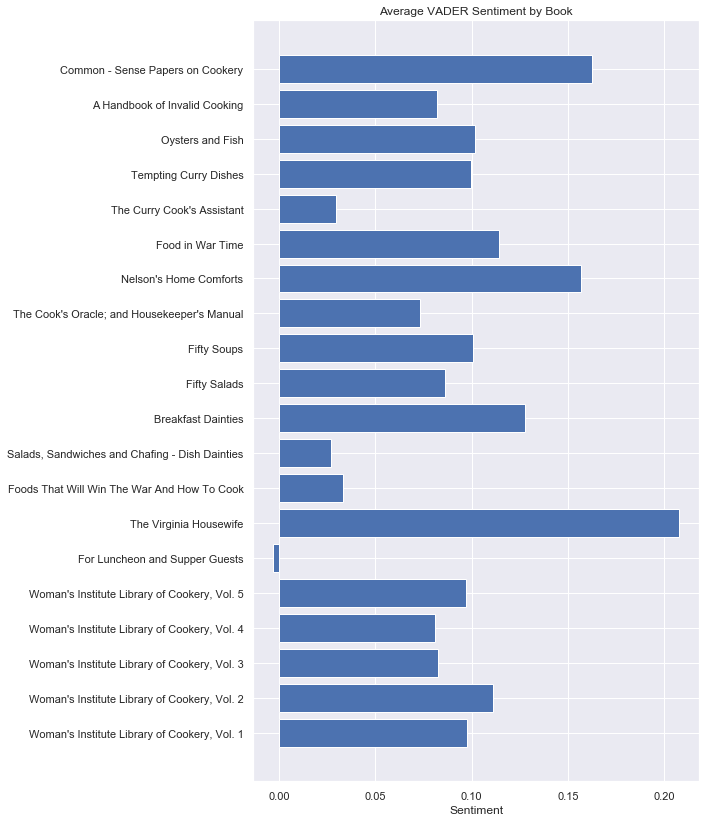

In [26]:
plt.figure(figsize=(8,14))
plt.barh(y=VADER_sentiment_book.book_title, width = VADER_sentiment_book.VADER_compound)
plt.xlabel("Sentiment", fontsize=12)
plt.title("Average VADER Sentiment by Book")

### Grouping by Period

In [27]:
VADER_sentiment_period = sent_frame.groupby(OHCO[:1]).mean()
VADER_sentiment_period

,VADER_pos,VADER_neg,VADER_neu,VADER_compound
period,,,,
1900s,0.055684,0.025045,0.904859,0.081174
late1800s,0.067625,0.038279,0.887327,0.104063
mid1800s,0.058593,0.091800,0.839795,0.091245


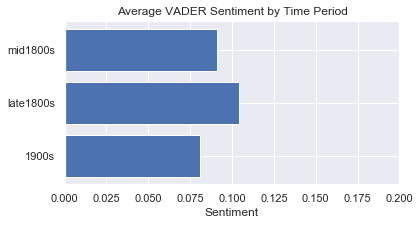

In [28]:
plt.figure(figsize=(6,3))
plt.barh(y=VADER_sentiment_period.index, width = VADER_sentiment_period.VADER_compound)
plt.xlabel("Sentiment", fontsize=12)
plt.xlim(0,.2)
plt.title("Average VADER Sentiment by Time Period")
plt.show()

### Writing VADER Results to .csv

In [29]:
VADER_sentiment_book.to_csv(data_dir + 'VADER_sentiment_book.csv')
VADER_sentiment_period.to_csv(data_dir + 'VADER_sentiment_period.csv')

## Sentiment with NRC

In [45]:
sentiment = pd.read_csv(data_dir + 'emolex_sentiment.csv') #reading in the NRC sentiment data
sentiment.head()

,term_str,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust
0,abandon,0,0,0,1,0,1,0,1,0,0
1,abandoned,1,0,0,1,0,1,0,1,0,0
2,abandonment,1,0,0,1,0,1,0,1,1,0
3,abduction,0,0,0,1,0,1,0,1,1,0
4,aberration,0,0,1,0,0,1,0,0,0,0


In [47]:
NRC = pd.merge(TOKEN, sentiment, on='term_str', how='left') #merging in the sentiment data to the TOKENS table
NRC.iloc[:,-10:] = NRC.iloc[:,-10:].fillna(0) #filling any missing sentiment values with zero 
NRC_emo = NRC[NRC.stop==0] #removing stopwords
NRC_emo = NRC_emo[NRC_emo.has_int == 0] #removing integers
NRC_emo = NRC_emo[(NRC_emo.pos != 'NNP') & (NRC_emo.pos != 'NNPS')] #removing proper nouns
NRC_emo.head()

,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,author_last,author_full,book_year,book_title,book_file,period,term_id,Unnamed: 2,n,num,has_int,stop,stem_porter,stem_snowball,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust
3,9935,1,1,1.0,0,1,0,"('Without', 'IN')",IN,Without,without,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,16577,NaN,751,0,0,0,without,without,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9935,1,1,1.0,0,1,1,"('doubt', 'NN')",NN,doubt,doubt,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,5252,NaN,63,0,0,0,doubt,doubt,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
6,9935,1,1,1.0,0,1,4,"('greatest', 'JJS')",JJS,greatest,greatest,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,7253,NaN,93,0,0,0,greatest,greatest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,9935,1,1,1.0,0,1,5,"('problem', 'NN')",NN,problem,problem,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,11883,NaN,18,0,0,0,problem,problem,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
8,9935,1,1,1.0,0,1,6,"('confronting', 'VBG')",VBG,confronting,confronting,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,3871,NaN,1,0,0,0,confront,confront,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating Sentiment for Period

In [49]:
NRC_period_sentiment = NRC_emo.groupby(OHCO[:1]).mean().drop(['Unnamed: 2','book_id', 'vol_num', 'chap_num','recp_num','para_num','sent_num','token_num','book_year','term_id','n','num','has_int','stop'], axis=1) #dropping out all the columns we don't need
NRC_period_sentiment['overall_valence'] = NRC_period_sentiment.nrc_positive - NRC_period_sentiment.nrc_negative #adding a column for overall valence
NRC_period_sentiment


,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,overall_valence
period,,,,,,,,,,,
1900s,0.012005,0.024323,0.014569,0.013058,0.034571,0.033926,0.051091,0.018929,0.011475,0.044281,0.017165
late1800s,0.017366,0.026635,0.017846,0.016050,0.032417,0.041533,0.046556,0.020689,0.014437,0.039717,0.005023
mid1800s,0.017872,0.027646,0.019028,0.011857,0.034673,0.042558,0.047484,0.017814,0.016455,0.042500,0.004926


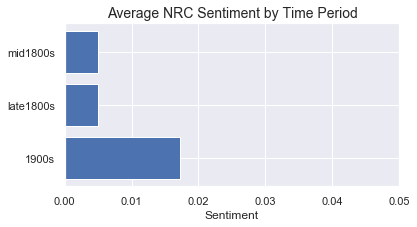

In [50]:
plt.figure(figsize=(6,3))
plt.barh(y=NRC_period_sentiment.index, width = NRC_period_sentiment.overall_valence)
plt.xlabel("Sentiment", fontsize=12)
plt.xlim(0,.05)
plt.title("Average NRC Sentiment by Time Period", fontsize=14)
plt.show()

### Calculating Sentiment for Book

In [52]:
NRC_book_sentiment = NRC_emo.groupby(OHCO[:2]).mean().drop(['Unnamed: 2','vol_num', 'chap_num','recp_num','para_num','sent_num','token_num','book_year','term_id','n','num','has_int','stop'], axis=1) #book
NRC_book_sentiment['overall_valence'] = NRC_book_sentiment.nrc_positive - NRC_book_sentiment.nrc_negative #adding a column for the overall valence
NRC_book_sentiment

nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  \
period    book_id                                                       
1900s     9935      0.009299          0.024444     0.012312  0.011359   
          9936      0.012711          0.027397     0.016529  0.015915   
          9937      0.014478          0.020032     0.018361  0.016231   
          9938      0.008870          0.025764     0.011702  0.010807   
          9939      0.011967          0.027539     0.011523  0.014888   
          10582     0.024581          0.028269     0.010754  0.010447   
          15464     0.009789          0.013263     0.029051  0.007263   
          19077     0.014568          0.022440     0.010089  0.009263   
          32472     0.014251          0.027778     0.023913  0.021981   
late1800s 24205     0.020833          0.029046     0.014423  0.015224   
          24542     0.017505          0.039387     0.017505  0.010941   
          25007     0.023946          0.016918     0.022124  0.014315   
          29519     0.019100          0.022920     0.017878  0.009703   
          34107     0.016000          0.027459     0.015135  0.006054   
          38464     0.021808          0.022160     0.009497  0.007387   
          53521     0.030921          0.023935     0.015918  0.022790   
          54568     0.012689          0.027824     0.017743  0.016748   
          61185     0.016800          0.028624     0.019871  0.018953   
mid1800s  12519     0.018886          0.024028     0.018385  0.009420   
          28681     0.017599          0.028618     0.019201  0.012511   

                    nrc_joy  nrc_negative  nrc_positive  nrc_sadness  \
period    book_id                                                      
1900s     9935     0.035494      0.026247      0.055586     0.015017   
          9936     0.041149      0.038586      0.061337     0.022778   
          9937     0.031599      0.040847      0.049636     0.027959   
          9938     0.033491      0.030584      0.048497     0.014957   
          9939     0.039244      0.029514      0.056831     0.016439   
          10582    0.033799      0.043478      0.043325     0.013059   
          15464    0.022610      0.043893      0.030630     0.025641   
          19077    0.025527      0.032007      0.034355     0.011611   
          32472    0.044686      0.044686      0.069082     0.032609   
late1800s 24205    0.030449      0.044271      0.048478     0.018830   
          24542    0.030635      0.052516      0.052516     0.017505   
          25007    0.019781      0.053097      0.027069     0.019521   
          29519    0.027886      0.042937      0.037054     0.017801   
          34107    0.030270      0.027027      0.036973     0.008216   
          38464    0.020049      0.038692      0.031305     0.011256   
          53521    0.025080      0.059895      0.035731     0.027142   
          54568    0.036185      0.036803      0.053309     0.021399   
          61185    0.035506      0.041859      0.050718     0.022624   
mid1800s  12519    0.029990      0.048102      0.036589     0.015109   
          28681    0.035932      0.041068      0.050412     0.018541   

                   nrc_surprise  nrc_trust  overall_valence  
period    book_id                                            
1900s     9935         0.010355   0.048064         0.029338  
          9936         0.013325   0.051937         0.022751  
          9937         0.010111   0.048881         0.008789  
          9938         0.011876   0.039528         0.017913  
          9939         0.012410   0.048672         0.027318  
          10582        0.016746   0.029805        -0.000154  
          15464        0.006758   0.028672        -0.013263  
          19077        0.010785   0.029398         0.002348  
          32472        0.015942   0.057005         0.024396  
late1800s 24205        0.011418   0.042067         0.004207  
          24542        0.008753   0.052516         0.000000  
          25007      

In [55]:
### merging with the LIB table
NRC_book_sentiment = pd.merge(NRC_book_sentiment, LIB, on="book_id")
NRC_book_sentiment.style.background_gradient(cmap='Greens')

,book_id,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,overall_valence,author_last_x,author_full_x,book_year_x,book_title_x,book_file_x,period_x,author_last_y,author_full_y,book_year_y,book_title_y,book_file_y,period_y,author_last,author_full,book_year,book_title,book_file,period
0,9935,0.009299,0.024444,0.012312,0.011359,0.035494,0.026247,0.055586,0.015017,0.010355,0.048064,0.029338,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 1",Cookbooks\WIDAS1923_WILCV01_pg9935.txt,1900s
1,9936,0.012711,0.027397,0.016529,0.015915,0.041149,0.038586,0.061337,0.022778,0.013325,0.051937,0.022751,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 2",Cookbooks\WIDAS1923_WILCV02_pg9936.txt,1900s,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 2",Cookbooks\WIDAS1923_WILCV02_pg9936.txt,1900s,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 2",Cookbooks\WIDAS1923_WILCV02_pg9936.txt,1900s
2,9937,0.014478,0.020032,0.018361,0.016231,0.031599,0.040847,0.049636,0.027959,0.010111,0.048881,0.008789,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 3",Cookbooks\WIDAS1923_WILCV03_pg9937.txt,1900s,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 3",Cookbooks\WIDAS1923_WILCV03_pg9937.txt,1900s,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 3",Cookbooks\WIDAS1923_WILCV03_pg9937.txt,1900s
3,9938,0.008870,0.025764,0.011702,0.010807,0.033491,0.030584,0.048497,0.014957,0.011876,0.039528,0.017913,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 4",Cookbooks\WIDAS1923_WILCV04_pg9938.txt,1900s,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 4",Cookbooks\WIDAS1923_WILCV04_pg9938.txt,1900s,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 4",Cookbooks\WIDAS1923_WILCV04_pg9938.txt,1900s
4,9939,0.011967,0.027539,0.011523,0.014888,0.039244,0.029514,0.056831,0.016439,0.012410,0.048672,0.027318,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 5",Cookbooks\WIDAS1923_WILCV05_pg9939.txt,1900s,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 5",Cookbooks\WIDAS1923_WILCV05_pg9939.txt,1900s,Cookbooks\WIDAS,Woman's Institute of Domestic Arts and Sciences,1923,"Woman's Institute Library of Cookery, Vol. 5",Cookbooks\WIDAS1923_WILCV05_pg9939.txt,1900s
5,10582,0.024581,0.028269,0.010754,0.010447,0.033799,0.043478,0.043325,0.013059,0.016746,0.029805,-0.000154,Cookbooks\Bradley,Alice Bradley,1923,For Luncheon and Supper Guests,Cookbooks\Bradley1923_FLSG_pg10582.txt,1900s,Cookbooks\Bradley,Alice Bradley,1923,For Luncheon and Supper Guests,Cookbooks\Bradley1923_FLSG_pg10582.txt,1900s,Cookbooks\Bradley,Alice Bradley,1923,For Luncheon and Supper Guests,Cookbooks\Bradley1923_FLSG_pg10582.txt,1900s
6,15464,0.009789,0.013263,0.029051,0.007263,0.022610,0.043893,0.030630,0.025641,0.006758,0.028672,-0.013263,Cookbooks\Goudiss,Alice Bradley,1918,Foods That Will Win The War And How To Cook,Cookbooks\Goudiss1918_War_pg15464.txt,1900s,Cookbooks\Goudiss,Alice

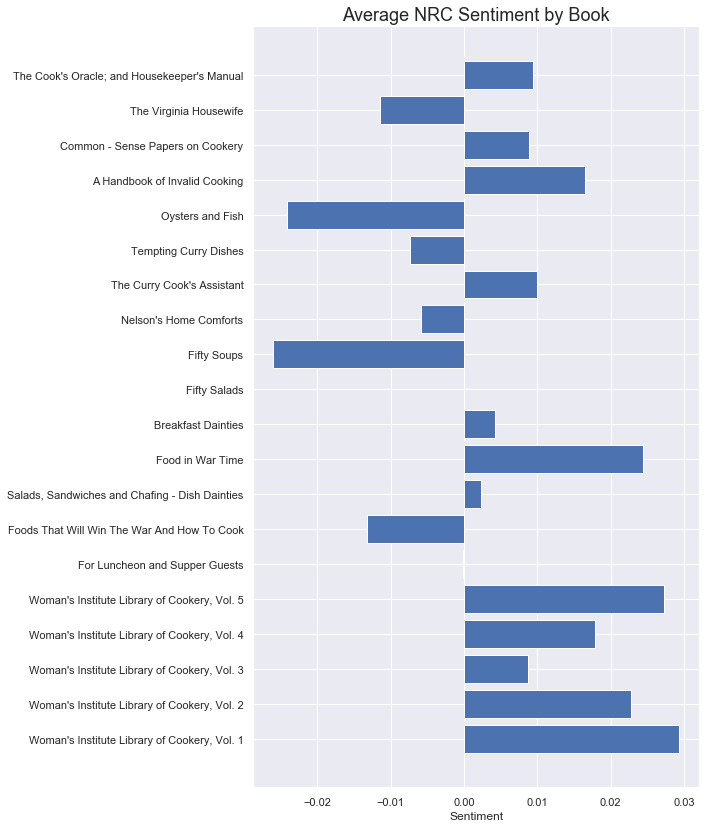

In [58]:
plt.figure(figsize=(8,14))
plt.barh(y=NRC_book_sentiment.book_title, width = NRC_book_sentiment.overall_valence)
plt.xlabel("Sentiment", fontsize=12)
plt.title("Average NRC Sentiment by Book", fontsize=18)
plt.show()

### NRC to .csv

In [59]:
NRC_book_sentiment.to_csv(data_dir + 'NRC_book_sentiment.csv')
NRC_period_sentiment.to_csv(data_dir + 'NRC_period_sentiment.csv')